In [2]:
from IPython.display import display
import scipy as sp
import numpy as np
import scipy.stats
import pandas as pd
from math import log
from scipy.optimize import curve_fit
#from sklearn import datasets, linear_model
import matplotlib as mpl
import matplotlib.pyplot as plt
import math as mt
from scipy.stats import chi2
from scipy.interpolate import interp1d
#from matplotlib2tikz import save as tikz_save

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    display(Markdown(df_formatted.to_csv(sep="|", index=False)))

# La funzione chiq prende come parametri i valori teorici, le osservazioni, e gli errori sulle osservazioni
def chiq(exp, obs, obsErr):
    return sum(np.power((exp - obs),2)/np.power(obsErr,2))

# La funzione testchiq prende come parametri i gradi di libertà, quantile inf, quantile sup e valore del chi quadro
def testchiq(degf,infq,supq,valchiq):
    infchiq = chi2.isf(q=1-infq, df=degf);
    supchiq = chi2.isf(q=1-supq, df=degf);
    print('Chi quadrato per modello e osservazioni: %f.' % valchiq )
    print('Studiamo se il chi quadro è nel range [%f, %f]' % (infchiq, supchiq))
    if (valchiq <= supchiq) & (valchiq >= infchiq):
        print(color.BOLD + color.GREEN + 'Test del chi quadro superato!' + color.END + color.END)
    else:
        print(color.BOLD + color.RED + 'Test del chi quadro non superato!'+ color.END + color.END)

# La funzione stattest prende come parametri valore 1, errore 1, valore 2, errore 2, e infine il fattore di copertura.
def stattest(val1, val2, err1, err2, kcop):
    R = abs(val1 - val2)
    errR = np.sqrt(err1**2 + err2**2)
    infconf = R - kcop * errR
    supconf = R + kcop * errR
    if (0 > infconf) & (0 < supconf):
        print(color.BOLD + color.GREEN + 'Il test è superato con una confidenza di %.0f sigma!' % (kcop) + color.END + color.END)
    else:
        print(color.BOLD + color.RED + 'Il test non è superato con un confidenza di %.0f sigma' % (kcop) + color.END + color.END)
        
def constfunc(q):
    return q

def linfunc(x,m,q):
    return m*x + q

def lferr(x,y,yerr):
    w = 1/np.power(yerr,2)
    Delta = sum(w) * sum(w*np.power(x,2)) - np.power(sum(w*x),2)
    qerr = np.sqrt(sum(w)/Delta)
    merr = np.sqrt(sum(w*np.power(x,2))/Delta)
    return (qerr, merr)

def dirfunc(x,m):
    return m*x

def epmult(q1,q2,e1,e2):
    q = abs(q1 * q2)
    return np.sqrt(np.power((e1/q1),2)+np.power((e2/q2),2)) * q
def epdiv(q1,q2,e1,e2):
    q = abs(q1 / q2)
    return np.sqrt(np.power((e1/q1),2)+np.power((e2/q2),2)) * q
def epsum(e1,e2):
    return np.sqrt(np.power(e1,2)+np.power(e2,2))
def eppow(q1,e1,p):
    qp = np.power(q1,p)
    return abs(qp) * p * (e1/abs(q1))

def wavgerr(w):
    return 1/np.sqrt(sum(w))

# Imposto le costanti e le risoluzioni di misura
mmhg = 133.322368
mbar = 100
g = 9.8071
rhoH2O = 1e3
Dmass = 1e-4 # Espresso in kg
Dtime = 1e-2 # Espresso in sec
Dlength = 1e-3 # Espresso in m, riferito al metro a nastro
Dcalip = 5e-5 # Espresso in m, riferito al calibro

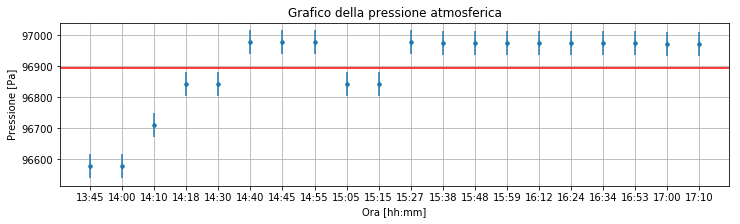

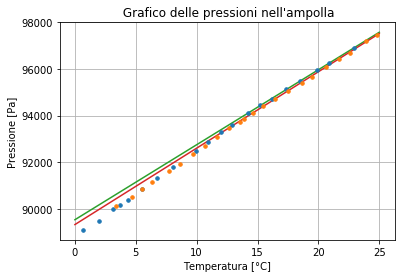

array([-278.0864545])

array([-272.27650759])

In [12]:
tempris = 0.01
heightris = 0.001
temperr = tempris/np.sqrt(12)
heighterr = heightris/np.sqrt(12)

# Importo i dati di andata (raffreddamento) e assegno le variabili
set3 = pd.read_csv('set3.csv')
time3 = set3['time']
hour3 = set3['hour']
temp3 = set3['temp']
height3 = set3['height']
dHeight3 = height3 - height3[0]

# Importo i dati di ritorno (riscaldamento) e assegno le variabili
set4 = pd.read_csv('set4.csv')
time4 = set4['time']
hour4 = set4['hour']
temp4 = set4['temp']
height4 = set4['height']
dHeight4 = height4 - height3[0]

# Importo i dati accessori:
# - L'ora a cui sono stati prese le misure (hour)
# - il dislivello sulla colonnina di mercurio (dhmg in mmHg → Pa)
# - la pressione residua del vuoto del mercurio (presres in mbar → Pa)
# - l'umidità relativa
# - i minuti passati dalle 13:45
dfmeteo = pd.read_csv('pressure.csv')
hourmeteo = dfmeteo['hour']
dhmg = dfmeteo['dhmg']* 10 * mmhg
dhmgerr = 1/np.sqrt(12) * mmhg
presres = dfmeteo['pres'] * mbar
presreserr = 0.1/np.sqrt(12) * mbar
relhum = dfmeteo['relhum']
timemeteo = dfmeteo['time']

# Calcolo la media della pressione atmosferica
patm = dhmg + presres
patmerr = np.sqrt(dhmgerr**2 + presreserr**2)
avgpatm = np.mean(patm)

# Figura 6.1: Grafico dei dati di pressione atmosferica
fig6_1 = plt.figure(figsize=(12,3))
plt.title('Grafico della pressione atmosferica')
plt.grid()
plt.ylabel('Pressione [Pa]')
plt.xlabel('Ora [hh:mm]')
plt.axhline(y=avgpatm, color="#FF0000")
plt.errorbar(hourmeteo, patm, yerr=patmerr, fmt=' ', marker='.', ms=7, capsize=0)
plt.show()

# Calcolo la pressione dell'ampolla
p3 = avgpatm + dHeight3 * rhoH2O * g
p4 = avgpatm + dHeight4 * rhoH2O * g

popt6a, pcov6a = curve_fit(linfunc, temp3[:9], p3[:9])
popt6b, pcov6b = curve_fit(linfunc, temp4[13:], p4[13:])

# Figura 6: Pressione in funzione della temperatura
fig6 = plt.figure()
plt.title(' Grafico delle pressioni nell\'ampolla')
plt.grid()
plt.xlabel('Temperatura [°C]')
plt.ylabel('Pressione [Pa]')
plt.errorbar(temp3, p3, label='Raffreddamento', fmt=' ', marker='.', ms=7, capsize=0)
plt.errorbar(temp4, p4, label='Riscaldamento', fmt=' ', marker='.', ms=7, capsize=0)
plt.plot(np.linspace(0,25), linfunc(np.linspace(0,25), *popt6a))
plt.plot(np.linspace(0,25), linfunc(np.linspace(0,25), *popt6b))
plt.show()

display(np.roots(popt6a), np.roots(popt6b))

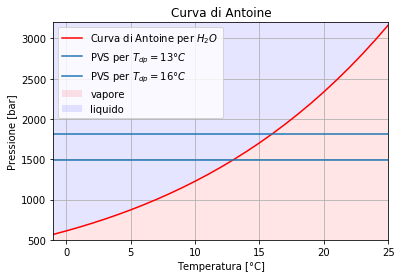

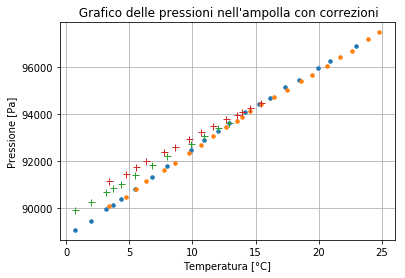

In [23]:
# È l'ora di fare qualche correzione!
# Provo a fittare i dati di quest'equazione...
def pvs(Tc):
    A = 5.40221
    B = 1838.675
    C = -31.737
    T = Tc + 273.15
    lP = A - (B/(T+C))
    P = 10**lP
    P = P * 1e5
    return P

xaux1 = np.array([-273.15, 13])
yaux1 = np.array([0, pvs(13)])
aux1m = (yaux1[1]-yaux1[0])/(xaux1[1]-xaux1[0])
aux1q = (xaux1[0]*yaux1[0] - xaux1[1]*yaux1[0])/(xaux1[0]-xaux1[1])

ietemps = np.arange(-5,27)
figaux1 = plt.figure()
plt.title('Curva di Antoine')
plt.plot(ietemps,pvs(ietemps),color='#ff0000',label='Curva di Antoine per $H_2O$')
plt.axhline(y=pvs(13),label='PVS per $T_{dp}=13 °C$')
plt.axhline(y=pvs(16),label='PVS per $T_{dp}=16 °C$')
plt.fill_between(ietemps,pvs(ietemps).min(),pvs(ietemps),facecolor='red',alpha=0.1,label='vapore')
plt.fill_between(ietemps,pvs(ietemps).max(),pvs(ietemps),facecolor='blue',alpha=0.1,label='liquido')
plt.legend()
plt.xlim([-1, 25])
plt.ylim([500, 3200])
plt.ylabel('Pressione [bar]')
plt.xlabel('Temperatura [°C]')
plt.grid()
plt.show()

dpcorra = pvs(13) - pvs(temp3[8:])
dpcorrb = pvs(16) - pvs(temp4[:14])
p5a = p3[8:] + dpcorra
p6a = p4[:14] + dpcorrb

# Figura 7: Pressione in funzione della temperatura con le correzioni
fig6 = plt.figure()
plt.title(' Grafico delle pressioni nell\'ampolla con correzioni')
plt.grid()
plt.xlabel('Temperatura [°C]')
plt.ylabel('Pressione [Pa]')
plt.errorbar(temp3, p3, label='Raffreddamento', fmt=' ', marker='.', ms=7, capsize=0)
plt.errorbar(temp4, p4, label='Riscaldamento', fmt=' ', marker='.', ms=7, capsize=0)
plt.errorbar(temp3[8:], p5a, fmt=' ', marker='+', ms=7, capsize=0)
plt.errorbar(temp4[:14], p6a, fmt=' ', marker='+', ms=7, capsize=0)
#plt.plot(np.linspace(0,25), linfunc(np.linspace(0,25), *popt6a))
#plt.plot(np.linspace(0,25), linfunc(np.linspace(0,25), *popt6b))
plt.show()